In [1]:
%matplotlib inline
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1)

## 1. Loading the data

I'm going to use the [breast cancer wisconsin dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), it's a binary classification dataset.

In [3]:
X, y = load_breast_cancer(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In other to feed the data to the model, we have to convert the numpy arrays into PyTorch tensors using `torch.from_numpy` and wrap them with `torch.autograd.Variable`

In [5]:
X_train_var = Variable(torch.from_numpy(X_train)).float()
y_train_var = Variable(torch.from_numpy(y_train)).float()
X_test_var  = Variable(torch.from_numpy(X_test)).float()
y_test_var  = Variable(torch.from_numpy(y_test)).float()

## 2. Bulding the model


The model itself is as simple as possible:

$$\hat{y} = \sigma(\mathbf{w}\cdot \mathbf{x} + b)$$

Where $\sigma$ is the logistic function:

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

A pytorch model is a subclass of `nn.Module`. We define all the layers in the constructor method and comput a foward pass in `foward`. The backward function is defined automatically by autograd.


In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return F.sigmoid(self.linear(x)).view(-1) # change output shape from [n_samples, 1] to [n_samples]
    
model = LogisticRegression(X_train.shape[1])

## 3. Loss function and optimizer

The loss function is the binary cross entropy:

$$ \mathcal L = - \frac1N \sum_{i=1}^N\left[ y_i \cdot \log \hat{y}_i + (1 - y_i) \cdot \log (1 - \hat{y}_i) \right] $$

And the optimizer is `torch.optim.Adam`: 

In [7]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

## 4. Training loop

Since this dataset is small and I just want to do a quick test, I will feed the whole data to the model at once. PyTorch encourages you to use it's [dataset class](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html), it makes it easy to divide the data in batches, shuffle before every epoch and apply some preprocessing function. If you want, you can use `torch.utils.data.TensorDataset` to [convert a tensor to a Dataset](https://discuss.pytorch.org/t/convert-numpy-to-pytorch-dataset/743).

In [8]:
history = {'loss': [], 'val_loss': []}

for epoch in range(1500):
    
    loss = criterion(model(X_train_var), y_train_var)
    val_loss = criterion(model(X_test_var), y_test_var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history["loss"].append(loss.data[0])
    history["val_loss"].append(val_loss.data[0])
    

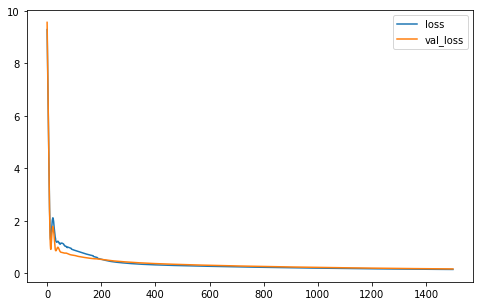

In [9]:
history = pd.DataFrame(history)
history.plot(figsize=(8,5))

## 5. Inference

I'll use a nice little snippet from scikit-learn to plot the ROC curve (although I don't really care about the results..)


In [10]:
y_pred = model(X_test_var).data.numpy()

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc  = roc_auc_score(y_test, y_pred)

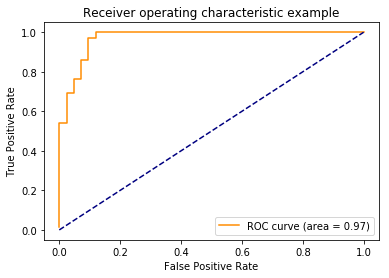

In [12]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()